# Graph Convolutional Network Demo

Notebook created by Rui Valente de Almeida, for the ISM PhD Course;
FCT NOVA, 2019

This notebook aims to show how we can create and "operate" a Graph Neural Network (in this case, spectral convolution type) using the DGL platform, which was itself built over pytorch. This particular examples is DGL's GCN example tutorial, with some minor changes for visualisation and dataset grabbing.

[Here's the link for the framework!](https://github.com/dmlc/dgl)

## Imports and initial settings

We begin this notebook by doing the usual thing in Python: importing everything we need for the program to run. In this case, this includes DGL's libraries and come of Pytorch's neural network structures, as well as some more "general purpose" tools like pathlib's Path (which I recommend you learn and use!).

We also define the message and reduce functions, which will are responsible for aggregating and updating the network at each step.

In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
from pathlib import Path
import networkx as nx
import time
import numpy as np
import matplotlib.pyplot as plt


gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

## Working class definitions

Here, we define the classes with which we will interact. This is one of pytorch's principles: each time we want to define a network to be run somewhere, we create a class inheriting from nn.Module and we write the class using the dunder init and the forward methods. A more complex model not only inherits, but is also composed of other nn.Module children classes. Net is an example of a complex model: notice the two network layers defined as GCN models in the dunder init method. 

Class `NodeApplyModule` applies a linear transformation and a (presumably) non-linear activation to the group of features that is entered as input

In [2]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

Class `GCN` defines the graph convolutional networks that we are using. Its forward method applies the transformations defined in `NodeApplyModule` and updates weights accordingly, using message and reduce functions to convolute the data.

In [3]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

Class `Net`defines the model itself, which implements two GCN layers of a set number of features and defines the activation function used in `NodeApplyModule`, which in this example is a relu. We print the model so that we can peek at the structure.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(1433, 16, F.relu)
        self.gcn2 = GCN(16, 7, F.relu)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


## Dataset Loading

In this code block, we define the function that grabs data from a given location, preprocesses and then returns them ready for pluging into the ANN. The `CitGraph`class was defined in order to harness DGL's examples' class structure with a foreign dataset. It was created because the original one had a wrongly defined url and was therefore unable to fetch the dataset.

In [5]:
# Dataset Loading
class CitGraph(citegrh.CoraDataset):
    def __init__(self, dpath):
        self.dir = str(dpath)
        self.name = 'cora'
        self._load()
    
def load_cora_data():
    datapath = Path.home() / 'data' / 'dgl'
    #data = citegrh.load_cora()
    data = CitGraph(datapath)
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = data.graph
    # add self loop
    g.remove_edges_from(g.selfloop_edges())
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask

## Fetching and preparing data; Plotting the graph

These next two code cells run the functions from the previous cell, fetching the data and preparing them for the ANN. The second cell plots the graph using matplotlib's pyplot. It does take a long time to run, and sometimes does not plot anything. I don't know why.

In [6]:
g, features, labels, mask = load_cora_data()

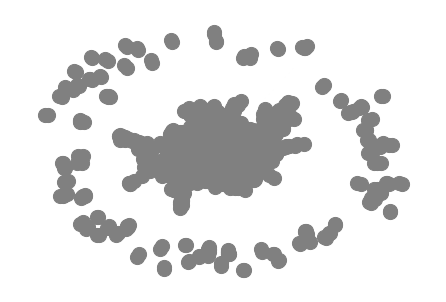

In [7]:
nx.draw(g.to_networkx(), node_size=200, node_color=[[.5, .5, .5,]])
plt.show()

## Training the network

Finally, we train the network we have created. We use the `Net`object we have instanced some cells above, set an optimizer and some loss functions and run training for 30 epochs (30 complete cycles). We also print out the time it takes to train the model, updated at each epoch.

In [8]:
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
dur = []
for epoch in range(30):
    if epoch >=3:
        t0 = time.time()

    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), np.mean(dur)))

/home/paperspace/anaconda3/envs/dgl/lib/python3.7/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)
/home/paperspace/anaconda3/envs/dgl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/paperspace/anaconda3/envs/dgl/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 1.9473 | Time(s) nan
Epoch 00001 | Loss 1.9346 | Time(s) nan
Epoch 00002 | Loss 1.9241 | Time(s) nan
Epoch 00003 | Loss 1.9144 | Time(s) 0.3964
Epoch 00004 | Loss 1.9054 | Time(s) 0.3943
Epoch 00005 | Loss 1.8960 | Time(s) 0.3929
Epoch 00006 | Loss 1.8865 | Time(s) 0.3923
Epoch 00007 | Loss 1.8765 | Time(s) 0.3913
Epoch 00008 | Loss 1.8664 | Time(s) 0.3900
Epoch 00009 | Loss 1.8568 | Time(s) 0.3905
Epoch 00010 | Loss 1.8475 | Time(s) 0.3906
Epoch 00011 | Loss 1.8385 | Time(s) 0.3910
Epoch 00012 | Loss 1.8301 | Time(s) 0.3898
Epoch 00013 | Loss 1.8222 | Time(s) 0.3892
Epoch 00014 | Loss 1.8148 | Time(s) 0.3908
Epoch 00015 | Loss 1.8080 | Time(s) 0.3910
Epoch 00016 | Loss 1.8017 | Time(s) 0.3914
Epoch 00017 | Loss 1.7960 | Time(s) 0.3912
Epoch 00018 | Loss 1.7908 | Time(s) 0.3913
Epoch 00019 | Loss 1.7860 | Time(s) 0.3904
Epoch 00020 | Loss 1.7816 | Time(s) 0.3894
Epoch 00021 | Loss 1.7776 | Time(s) 0.3887
Epoch 00022 | Loss 1.7739 | Time(s) 0.3872
Epoch 00023 | Loss 1

This is one of the most basic tutorials available for DGL, in which one creates the structures and models that need to be implemented for working with GNNs. DGL's developers have published several other tutorials at [their tutorial page](https://docs.dgl.ai/en/latest/tutorials/models/index.html).